# Analysis

Cross tabulations and generalized linear models using [Samplics](https://github.com/samplics-org/samplics).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from typing import Optional, Literal, TypeAlias
from numpy import typing as npt
from samplics.categorical import CrossTabulation
from samplics.regression.glm import SurveyGLM
from samplics.estimation import TaylorEstimator
from statsmodels.stats.weightstats import DescrStatsW

gss: pd.DataFrame = pd.read_csv("data/Theo_extract_3-20-2023.csv")
gss_saf: pd.DataFrame = pd.read_csv("data/Safiya_extract_3-20-2023.csv")

# --------------------------------
# --- Quick clean up (ignore) ----
# --------------------------------
# Any number type (lazy)
Number: TypeAlias = np.number | float | pd.Int64Dtype
DescriptiveStats: TypeAlias = Literal[
    "mean", "median", "quantile", "std", "corrcoef", "cov"
]


def recode_party(partyid: Number) -> Literal["Democrat", "Republican", "Other", pd.NA]:
    """Recode and collapse GSS' `partyid` from numbers to a few strings.

    Parameters
    ----------
    partyid : Number

    Return
    ------
    Literal["Democrat", "Republican", "Other", pd.NA]
    """

    match partyid:
        case _ if pd.isna(partyid):
            return pd.NA
        case 0 | 1 | 2:
            return "Democrat"
        case 4 | 5 | 6:
            return "Republican"
        case 3 | 7:
            return "Other"
        case _:
            return pd.NA


def recode_degree(degree: Number) -> Literal["No degree", "HS or assoc", "College"]:
    """Recode and collapse degree into strings with less categories.

    Parameters
    ----------
    degree : Number

    Return
    ------
    Literal["No degree", "HS or assoc", "College"]
    """

    match degree:
        case _ if pd.isna(degree):
            return pd.NA
        case 0:
            return "No degree"
        case 1 | 2:
            return "HS or assoc"
        case 3 | 4:
            return "College"
        case _:
            return pd.NA


def recode_degree_binary(degree: Number) -> Literal["HS or less", "Some college"]:
    """Recode degree into a binary feature.

    Parameters
    ----------
    degree : Number

    Return
    ------
    Literal["HS or less", "Some college"]
    """

    match degree:
        case _ if pd.isna(degree):
            return pd.NA
        case 0 | 1:
            return "HS or less"
        case 2 | 3 | 4:
            return "Some college"
        case _:
            return pd.NA


def recode_income(income: Number) -> Literal["<$8K", "$8K to $15K", "$15K+"]:
    """Recode and collapse income into strings with less categories.

    (I have no idea why this variable is so weird or where it came from).

    Parameters
    ----------
    income : Number

    Return
    ------
    Literal["<$8K", "$8K to $15K", "$15K+"]
    """

    if pd.isna(income):
        return pd.NA
    elif income in range(1, 8):
        return "<$8K"
    elif income in [8, 9]:
        return "$8K to $15K"
    elif income in [10, 11, 12]:
        return "$15K+"
    else:
        return pd.NA


# R's political party
gss_saf["partyid"] = gss_saf["partyid"].map(recode_party).astype("category")

# **Obvious features**
gss_saf["degree"] = gss_saf["degree"].astype("Int64")
gss_saf["hs_or_college"] = gss_saf["degree"].map(recode_degree_binary)
gss_saf["degree"] = gss_saf["degree"].map(recode_degree).astype("category")

gss["degree"] = gss["degree"].astype("Int64")
gss["hs_or_college"] = gss["degree"].map(recode_degree_binary)
gss["degree"] = gss["degree"].map(recode_degree).astype("category")

sex_map: dict[str, str] = {1: "Male", 2: "Female"}
gss_saf["sex"] = gss_saf["sex"].astype("Int64").map(sex_map).astype("category")
gss["sex"] = gss["sex"].astype("Int64").map(sex_map).astype("category")

gss["income"] = gss["income"].astype("Int64").map(recode_income).astype("category")

# Only recoding the categories used
gss["ethnic"] = (
    gss["ethnic"].astype("Int64").map({1: "Africa", 17: "Mexico"}).astype("category")
)

# Does R speak a language other than English or Spanish?
gss_saf["othlang"] = (
    gss_saf["othlang"].astype("Int64").map({1: "Yes", 2: "No"}).astype("category")
)

# Immigration should be decreased (recoded from letin1a)
gss_saf["decrease_imm"] = (
    gss_saf["decrease_imm"]
    .astype("Int64")
    .map({1: "Decrease", 0: "Stay the same or increase"})
    .astype("category")
)

# How important is it for respondent's children to be able to think for themselves?
gss["thnkself"] = (
    gss["thnkself"]
    .astype("Int64")
    .map({1: "Most", 2: "Second", 3: "Third", 4: "Fourth", 5: "Last"})
    .astype("category")
)

# Does the respondent believe in life after death?
gss["postlife"] = gss["postlife"].map({1: "Yes", 2: "No"})

# Quantile binning for coninc
gss["coninc"] = gss_saf["coninc"]
gss["coninc_quantiles"] = pd.qcut(gss["coninc"], 4)

gss["region"] = (
    gss["region"]
    .astype("Int64")
    .map(
        dict(
            zip(
                range(1, 10),
                [
                    "New England",
                    "Middle Atlantic",
                    "East North Central",
                    "West North Central",
                    "South Atlantic",
                    "East South Atlantic",
                    "West South Central",
                    "Mountain",
                    "Pacific",
                ],
            )
        )
    )
    .astype("category")
)

# Recode race
race_cats: dict[int, str] = {1: "White", 2: "Black", 3: "Other"}
gss["race"] = gss["race"].astype("Int64").map(race_cats).astype("category")
gss_saf["race"] = gss_saf["race"].astype("Int64").map(race_cats).astype("category")

# This variable is only valid for 2014.
gss["talkspvs"] = gss["talkspvs"].map(
    dict(
        zip(
            range(1, 6),
            ["Not comfortable at all", "A little", "Somewhat", "Very", "Extremely"],
        )
    )
)


## Descriptive stats

Samplics supports a few descriptive stats, but the package is currently incomplete. However, statsmodels has a [module](https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.DescrStatsW.html) for weighted stats that returns results that are equivalent (I think) to Samplics so we can use that.

In [2]:
mean_coninc = TaylorEstimator("mean")
mean_coninc.estimate(
    y=gss_saf["coninc"],
    samp_weight=gss_saf["wtssnrps"],
    # stratum=gss_saf["vstrat"],
    psu=gss_saf["vpsu"],
    remove_nan=True,
)

print(f"coninc:\n{mean_coninc}")


SAMPLICS - Estimation of Mean

Number of strata: 1
Number of psus: 3125
Degree of freedom: 3124

coninc:
        MEAN         SE          LCI         UCI       CV
53291.966659 883.234849 51560.187207 55023.74611 0.016574


The above code calculates the mean for `coninc` using Samplics' Taylor estimator. Writing the exact same code for each statistic violates D.R.Y. (don't repeat yourself) and thus is a good candidate for a function.

In [3]:
def descriptive_stats(
    y: pd.Series | npt.ArrayLike,
    samp_weight: pd.Series | npt.ArrayLike,
    stats: Optional[list[DescriptiveStats | dict[Literal["quantile"], float]]] = None,
    remove_null: Optional[bool] = False,
) -> pd.DataFrame:
    """Calculate weighted descriptive stats for an array.

    Parameters
    ----------
    y: pandas.Series | numpy.typing.ArrayLike
        Target array for the descriptive stats.
    samp_weight: pandas.Series | numpy.typing.ArrayLike
        Array of weights.
    stats: Optional[list[DescriptiveStats | dict[Literal["quantile"], float]]]
        List of statistics to calculate.
    remove_null: Optional[bool]
        Filter out nulls. Some calculations fail with NAs in the arrays.

    Returns
    -------
    pandas.DataFrame
        Calculated stats.
    """
    if not stats:
        stats = ["mean", "median", "std"]

    if remove_null:
        null_filter: npt.ArrayLike = np.isfinite(y)

        # Reduce null_filter's dimension and eagerly drop nulls
        if len(null_filter.shape) > 1 and null_filter.shape[1] > 1:
            null_filter = np.any(null_filter, axis=1)

        # Filter both arrays by the same boolean array for consistency
        y = y[null_filter]
        samp_weight = samp_weight[null_filter]

        # assert np.all(~np.isnan(y))

    # Column names if I have a Series/DataFrame
    col_names: Optional[pd.Index] = None
    if isinstance(y, (pd.Series, pd.DataFrame)):
        col_names = y.columns

    results: dict[str, npt.ArrayLike | pd.Series | pd.DataFrame] = {}
    descr_stats: DescrStatsW = DescrStatsW(y, samp_weight)

    for stat in stats:
        match stat:
            case "mean":
                results["mean"] = descr_stats.mean
            case "median":
                results["median"] = descr_stats.quantile(0.5)
            case "std":
                results["std"] = descr_stats.std
            case "corrcoef":
                results["corrcoef"] = descr_stats.corrcoef
            case "cov":
                results["cov"] = descr_stats.cov
            case {"quantile": probs}:
                results["quantile"] = descr_stats.quantile(probs)
            case _:
                raise ValueError(f"{stat} is an invalid statistic.")

    return results


descr_results = descriptive_stats(
    gss_saf[["coninc", "age"]],
    gss_saf["wtssnrps"],
    remove_null=True,
    stats=["mean", "median", "std", {"quantile": [0.25, 0.5, 0.75]}],
)

descr_results


{'mean': array([nan, nan]),
 'median':         col1  col2
 p                 
 0.5  40645.0  46.0,
 'std': array([nan, nan]),
 'quantile':          col1  col2
 p                  
 0.25  19277.5  32.0
 0.50  40645.0  46.0
 0.75  72600.0  61.0}

## Cross tabulations

Samplics implements cross tabulations of proportions and counts with its [CrossTabulation class](https://samplics-org.github.io/samplics/pages/categorical_tabulation.html).

In [4]:
tab_thnk_post = CrossTabulation("proportion")
tab_thnk_post.tabulate(
    vars=gss[["postlife", "thnkself"]],
    samp_weight=gss["wtssall"],
    # There isn't any stratification for the variables used
    # ...or there's only one PSU. Something like that.
    # stratum=gss["vstrat"],
    psu=gss["vpsu"],
    remove_nan=True,
)

print(tab_thnk_post)



Cross-tabulation of postlife and thnkself
 Number of strata: 1
 Number of PSUs: 2
 Number of observations: 8167
 Degrees of freedom: 1.00

 postlife thnkself  proportion  stderror  lower_ci  upper_ci
      No   Fourth    0.030365  0.002184  0.012053  0.074401
      No     Last    0.010181  0.000394  0.006219  0.016625
      No     Most    0.092465  0.001289  0.077340  0.110196
      No   Second    0.034407  0.000216  0.031767  0.037258
      No    Third    0.031475  0.000818  0.022583  0.043711
     Yes   Fourth    0.140978  0.009139  0.059188  0.299778
     Yes     Last    0.037669  0.000800  0.028721  0.049265
     Yes     Most    0.326757  0.003157  0.287977  0.368060
     Yes   Second    0.157055  0.000825  0.146851  0.167829
     Yes    Third    0.138646  0.002275  0.112183  0.170156

Pearson (with Rao-Scott adjustment):
	Unadjusted - chi2(4): 19.9821 with p-value of 0.0005
	Adjusted - F(1.00, 1.00): 6.1194  with p-value of 0.2446

  Likelihood ratio (with Rao-Scott adjustment):


## Generalized linear regression

In [5]:
# Explicitly drop NAs because remove_nan doesn't do it for some reason
gss_saf = gss_saf.dropna()

# Variable names for features
X_features = ["year", "age", "degree", "sex", "partyid", "coninc"]
X_imm_dummies = pd.get_dummies(gss_saf[X_features], drop_first=True)
X_imm_dummies = sm.add_constant(X_imm_dummies)

# Target feature
y_feature = pd.get_dummies(gss_saf["decrease_imm"], drop_first=True)

# I wish samplics wasn't incomplete.
# Fit the model
glm_imm = SurveyGLM()
glm_imm.estimate(
    y=y_feature,
    x=X_imm_dummies,
    samp_weight=gss_saf["wtssnrps"],
    # stratum=gss_saf["vstrat"],
    psu=gss_saf["vpsu"],
    remove_nan=True,
)

_results_imm_full = pd.DataFrame(
    [glm_imm.beta, *glm_imm.cov_beta],
    columns=X_imm_dummies.columns,
    index=["coef", *X_imm_dummies.columns],
).T

results_imm = pd.DataFrame(glm_imm.beta, columns=["coef"], index=X_imm_dummies.columns)

print(results_imm)


                            coef
const              -3.354384e+01
year                1.710328e-02
age                -3.047623e-03
coninc              2.204681e-07
degree_HS or assoc -1.433059e-01
degree_No degree   -1.120589e-01
sex_Male            2.046887e-02
partyid_Other      -1.073076e-01
partyid_Republican -2.690569e-01


In [6]:
# Binomial regression
glm_imm = sm.GLM(
    y_feature,
    X_imm_dummies,
    family=sm.families.Binomial(),
    var_weights=gss_saf["wtssnrps"],
    missing="drop",
)

results_imm = glm_imm.fit()
print(results_imm.summary())


                     Generalized Linear Model Regression Results                     
Dep. Variable:     Stay the same or increase   No. Observations:                 9045
Model:                                   GLM   Df Residuals:                     9036
Model Family:                       Binomial   Df Model:                            8
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -5462.6
Date:                       Sat, 01 Apr 2023   Deviance:                       10925.
Time:                               22:31:42   Pearson chi2:                 8.77e+03
No. Iterations:                            4   Pseudo R-squ. (CS):             0.1048
Covariance Type:                   nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

# Side by side plots

The following plots use Samplics to ensure proper weighting by calculating a cross tab of the variables.

Samplics throws a ["lonely PSU"](https://r-survey.r-forge.r-project.org/survey/exmample-lonely.html) exception because there is only only PSU per the strata (or something). I commented out the `stratum` parameter to squelch the error.

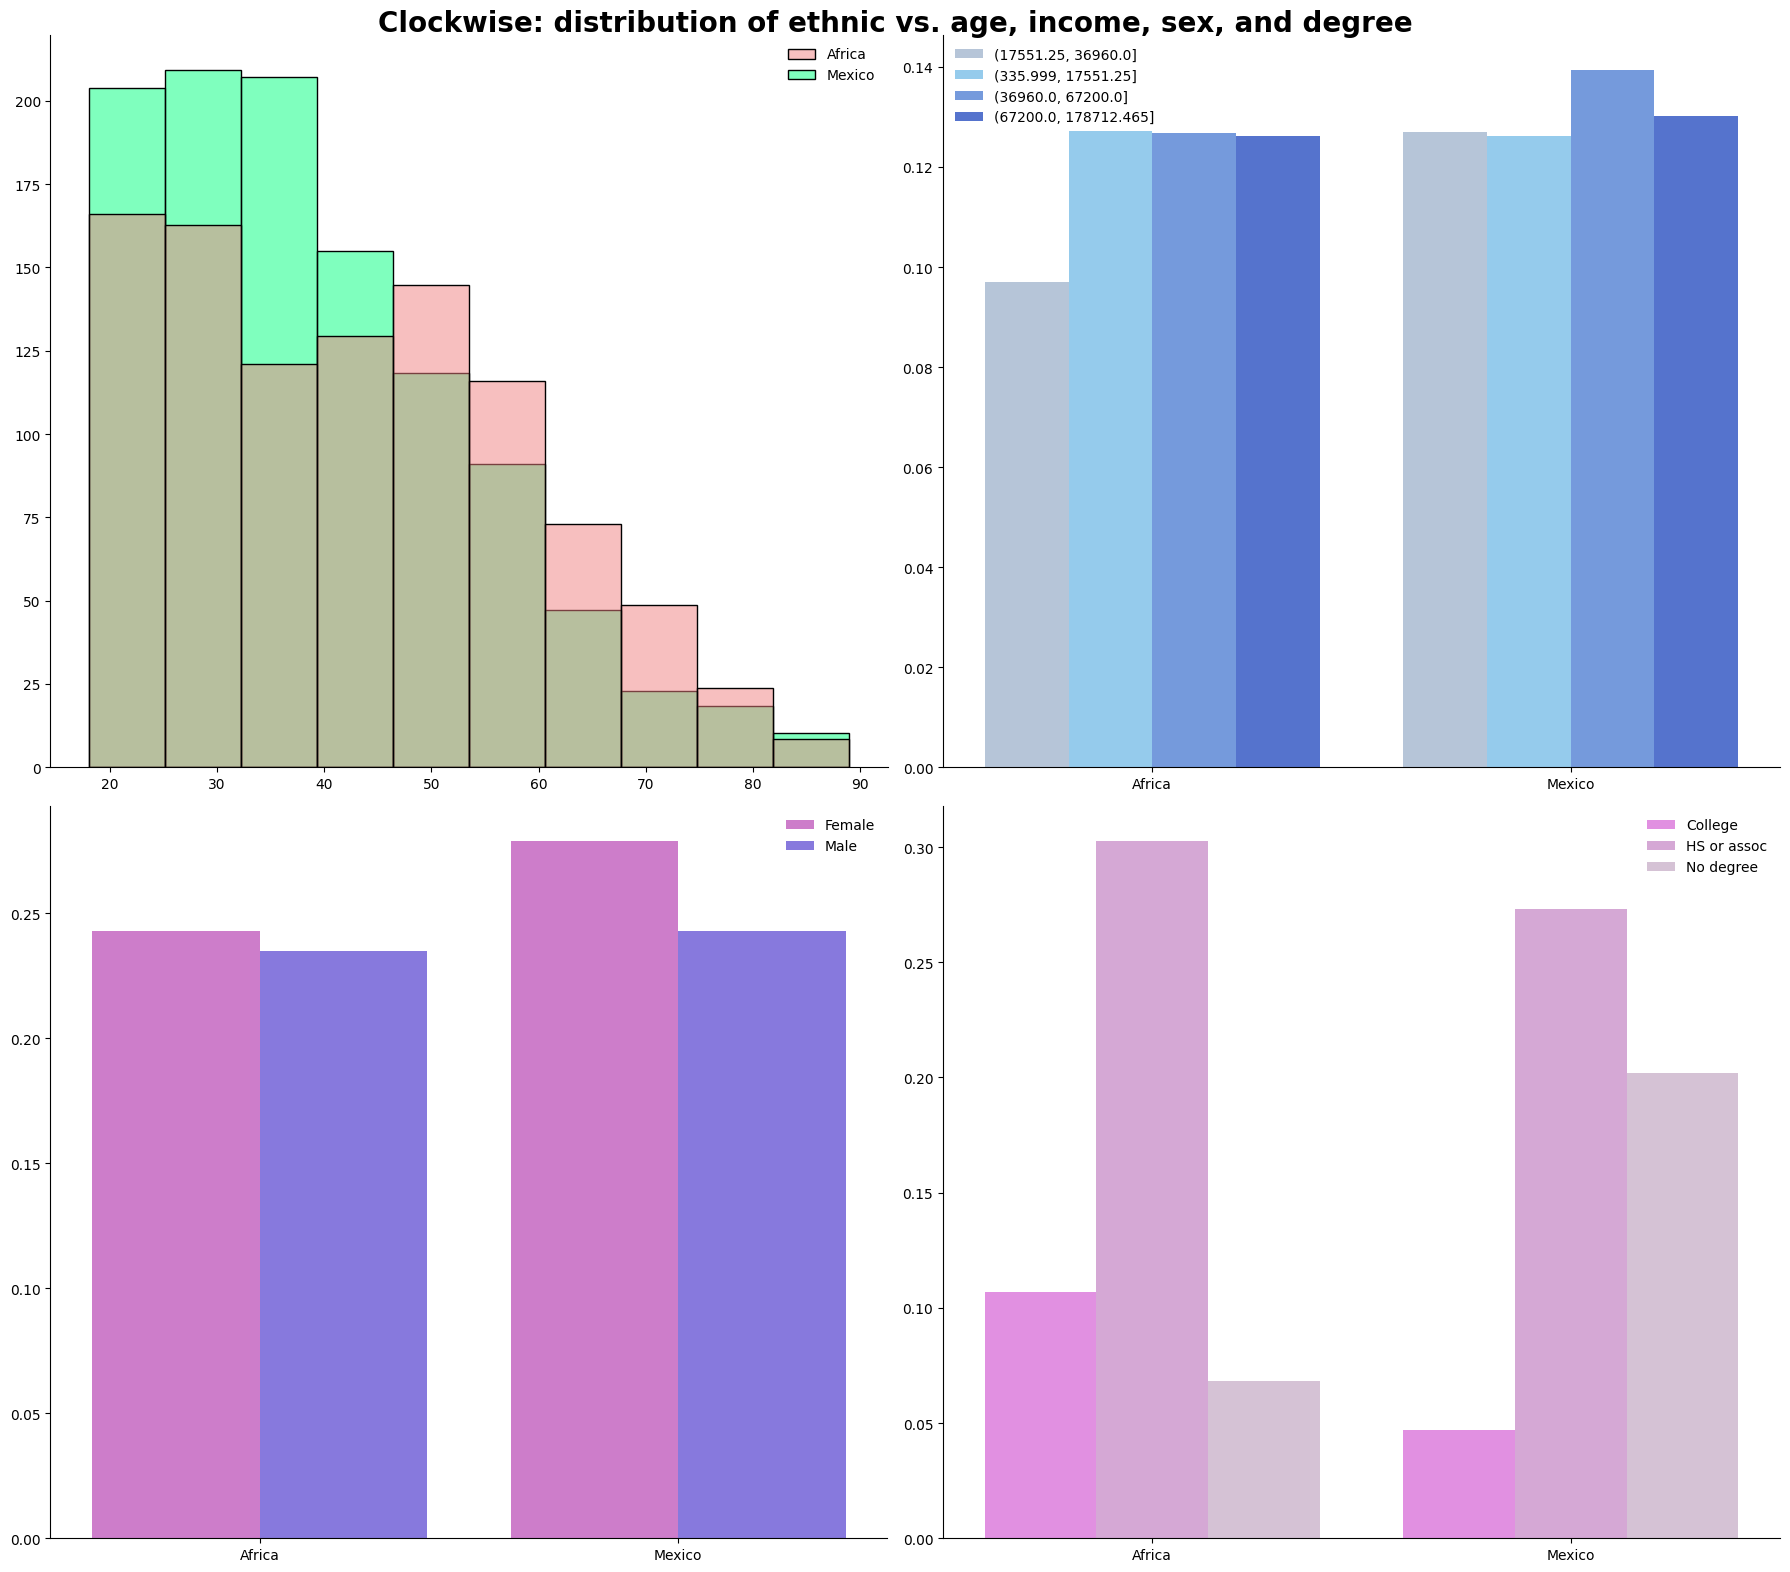

In [7]:
# Color maps
# Pan-African colors are red, green, and black
ethnicity = {"Africa": "lightcoral", "Mexico": "springgreen"}

gender = {"Female": "orchid", "Male": "mediumslateblue"}

income_bins = {
    "(335.999, 17551.25]": "lightskyblue",
    "(17551.25, 36960.0]": "lightsteelblue",
    "(36960.0, 67200.0]": "cornflowerblue",
    "(67200.0, 178712.465]": "royalblue",
}

degree = {
    "No degree": "thistle",
    "HS or assoc": "plum",
    "College": "violet",
}

# Two rows and two columns
comp_fig, comp_axes = plt.subplots(2, 2, figsize=(18, 16))

# The following code can be greatly simplified with a for loop, but it may
# be too confusing to follow for students with a shaky grasp on Python.
# I'll just write it out verbosely for now.

# Plot the age histogram on the first subplot
sns.histplot(
    gss,
    x="age",
    hue="ethnic",
    weights="wtssall",
    palette=ethnicity,
    bins=10,
    ax=comp_axes[0][0],
)

# Cross tabulate ethnic/income
ethn_inc = CrossTabulation("proportion")
ethn_inc.tabulate(
    vars=gss[["ethnic", "coninc_quantiles"]],
    samp_weight=gss["wtssall"],
    # Lonely PSU
    # stratum=gss["vstrat"],
    psu=gss["vpsu"],
    remove_nan=True,
)
ethn_inc = ethn_inc.to_dataframe()

# Plot cross tab on the second subplot
_ = sns.barplot(
    x=ethn_inc.ethnic,
    y=ethn_inc.proportion,
    hue=ethn_inc.coninc_quantiles,
    palette=income_bins,
    ax=comp_axes[0][1],
)

# Cross tabulate ethnic/sex
ethn_sex = CrossTabulation("proportion")
ethn_sex.tabulate(
    vars=gss[["ethnic", "sex"]],
    samp_weight=gss["wtssall"],
    # Lonely PSU
    # stratum=gss["vstrat"],
    psu=gss["vpsu"],
    remove_nan=True,
)
ethn_sex = ethn_sex.to_dataframe()

# Plot ethnic/sex cross tab
_ = sns.barplot(
    x=ethn_sex.ethnic,
    y=ethn_sex.proportion,
    hue=ethn_sex.sex,
    palette=gender,
    ax=comp_axes[1][0],
)

# Cross tabulate ethnic/degree
ethn_degr = CrossTabulation("proportion")
ethn_degr.tabulate(
    vars=gss[["ethnic", "degree"]],
    samp_weight=gss["wtssall"],
    # Lonely PSU
    # stratum=gss["vstrat"],
    psu=gss["vpsu"],
    remove_nan=True,
)
ethn_degr = ethn_degr.to_dataframe()

# Plot ethnic/degree cross tab
_ = sns.barplot(
    x=ethn_degr.ethnic,
    y=ethn_degr.proportion,
    hue=ethn_degr.degree,
    palette=degree,
    ax=comp_axes[1][1],
)

# Titles et cetera
for ax in comp_axes.flat:
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    # Remove legend title
    legend = ax.get_legend()
    legend.set_title(None)
    legend.draw_frame(False)

    # Remove plot spines
    sns.despine(comp_fig, ax)


_ = comp_fig.suptitle(
    "Clockwise: distribution of ethnic vs. age, income, sex, and degree",
    fontsize=20,
    fontweight="bold",
)

comp_fig.set_tight_layout(True)


## Saving a DataFrame

Pandas supports writing to many formats such as flat CSVs with [pandas.DataFrame.to_csv()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html), Parquet with [to_parquet()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html) as well as horrible formats like Excel.

You may select the features you're using and drop the rest if you'd like a smaller data set. However, if you're still wrangling and deciding on variables to use, you can just save your current work for now.

Pandas defaults to saving the index, but that makes little sense for basic indices that are just row counts.

In [8]:
# Select features
gss = gss[
    [
        "coninc",
        "coninc_quantiles",
        "degree",
        "hs_or_college",
        "income",
        "region",
        "age",
        "sex",
        "race",
        "talkspvs",
        "ethnic",
        "wtssall",
        "vstrat",
        "vpsu",
    ]
]
gss.to_csv("data/theo_clean.csv", index=False)

# And repeat
gss_saf = gss_saf.drop(columns=["letin1a", "age_c", "educ"])
gss_saf.to_csv("data/safiya_clean.csv", index=False)
